In [1]:
# Relevant Packages
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import pyart
import os

# suppress warnings
import warnings
warnings.filterwarnings("ignore")


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# Read in the lidar data
lidar_path = "../lidar_data/lidar-data-3-Aug.csv" # path to file can be changed as needed
dateNum = 3 # date number

lidar = pd.read_csv(lidar_path)
lidar = lidar.drop("Unnamed: 0", axis=1)

# check the lidar data imported
lidar

,Midtime,Latitude,Longitude,Fire ID,Pass #,MLH,Plume Height,MLH Estimate
0,78247.007,47.972,-116.836,10.0,1.0,2143.3048,-9999.0,2850.8139
1,78257.007,47.986,-116.855,10.0,1.0,2712.9095,-9999.0,2850.8139
2,78267.503,48.001,-116.876,10.0,1.0,2802.8473,-9999.0,2850.8139
3,78277.504,48.015,-116.895,10.0,1.0,3042.6808,-9999.0,2850.8139
4,78287.504,48.028,-116.915,10.0,1.0,3102.6393,-9999.0,2850.8139
...,...,...,...,...,...,...,...,...
1631,95231.503,48.461,-117.760,10.0,2.0,3012.7015,-9999.0,3069.1330
1632,95241.503,48.474,-117.761,10.0,2.0,2982.7224,-9999.0,3069.1330
1633,95252.007,48.487,-117.761,10.0,2.0,3012.7015,-9999.0,3069.1330
1634,95262.007,48.499,-117.761,10.0,2.0,3072.6600,-9999.0,3069.1330


In [3]:
# Convert lidar times
# to datetime format

# Lidar times
ltimes = np.array(lidar["Midtime"])

# change the unixtime accordingly
unixtime = 1564790400 # 3 August 2019 UTC
# unixtime = 1565049600 # 6 August 2019 UTC
# unixtime = 1565136000 # 7 August 2019 UTC 

# Convert the times to datetime format
ldelta = np.full(len(ltimes), unixtime)
lidartimes = ltimes + ldelta
lidartimes = np.array(lidartimes, dtype="datetime64[s]")

# check the lidar times to make sure they are correct
lidartimes

array(['2019-08-03T21:44:07', '2019-08-03T21:44:17',
       '2019-08-03T21:44:27', ..., '2019-08-04T02:27:32',
       '2019-08-04T02:27:42', '2019-08-04T02:27:52'],
      dtype='datetime64[s]')

In [4]:
# Now check if any lidar times are out of 
# range for the given day

# i.e., if it is 7 Aug 2019 PST - we need to check whether
# it is 8 Aug 2019 UTC. 
N = 0
for i, t in enumerate(lidartimes):
    if t > np.datetime64('2019-08-0'+str(dateNum)+'T23:59:59'):
        N = i
        print("N = ", i, t)
        break

N =  797 2019-08-04T00:00:03


In [5]:
"""
We will change the next_day boolean variable accordingly.
If we are inspecting the heights for 7 Aug UTC, next_day == False
If the heights are for 8 Aug UTC next_day == True
"""
next_day = False 

if N != 0:
    if next_day == False:
        ltimes = ltimes[:N]
    elif next_day == True:
        ltimes = ltimes[N:]

In [6]:
ltimes

array([78247.007, 78257.007, 78267.503, 78277.504, 78287.504, 78297.504,
       78308.007, 78318.006, 78328.007, 78338.504, 78348.503, 78358.504,
       78368.504, 78379.007, 78389.007, 78399.007, 78409.007, 78419.503,
       78429.504, 78439.504, 78450.007, 78460.007, 78470.503, 78481.007,
       78491.504, 78501.504, 78511.504, 78523.007, 78533.504, 78543.504,
       78553.503, 78563.503, 78573.504, 78584.007, 78594.007, 78604.503,
       78614.504, 78624.504, 78635.007, 78645.007, 78655.007, 78665.503,
       78675.504, 78685.504, 78696.504, 78708.007, 78718.504, 78728.504,
       78738.503, 78749.007, 78759.007, 78769.007, 78779.504, 78789.503,
       78799.504, 78810.007, 78820.007, 78830.007, 78840.504, 78850.504,
       78860.504, 78871.007, 78881.007, 78891.007, 78901.504, 78911.503,
       78921.504, 78931.503, 78942.007, 78952.007, 78962.007, 78972.007,
       78982.503, 78992.503, 79002.504, 79012.504, 79023.007, 79033.007,
       79043.007, 79053.504, 79063.503, 79073.503, 

In [7]:
# if you set next_day == True, 
# you need to increase the dateNum by 1
if next_day == True:
    dateNum += 1

In [8]:
# Reading in the Radar data - injection heights within grid box
path = "../Injection-Heights/new-injection-heights_3-Aug-2019.mat"
radar = sio.loadmat(path)

# checking radar data
radar

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Thu Dec  2 17:29:16 2021',
 '__version__': '1.0',
 '__globals__': [],
 'smoke_injection_height': array([[[-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         ...,
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.]],
 
        [[-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         ...,
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.]],
 
        [[-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         ...,
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
        

In [9]:
# Radar times
rtimes = np.array(radar["time"][0])
rtimes = rtimes + (24*60*60)

# # Change the unixtime accordingly
# # unixtime = 1565136000 # 7 August 2019 UTC
# unixtime = 1565222400 # 8 August 2019 UTC

# tdelta = np.full(len(rtimes), unixtime) # unixtime seconds from 1 Jan 1970 to given day

# radartimes = rtimes + tdelta
# radartimes = np.array(radartimes, dtype="datetime64[s]")

# # check the radar times to make sure they are correct
# radartimes

In [10]:
# Helper function to find nearest time
def nearest(times, tvalue):
    tarr = np.asarray(times)
    idx = (np.abs(tarr - tvalue)).argmin()
    return times[idx], idx

In [11]:
radartimes = np.array([])
rindexes = np.array([])
for t in np.asarray(ltimes):
    r, i = nearest(rtimes, t)
    print(r, i)
    radartimes = np.append(radartimes, r)
    rindexes = np.append(rindexes, i)

86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0
86447.0 0


In [12]:
#reorganized radar data
rdata = pd.DataFrame()

if N!= 0:
    if next_day == False:  
        rdata['lidar_times'] = np.asarray(ltimes)
        rdata['radar_times'] = radartimes
        rdata['time_index'] = rindexes
        rdata['lidar_heights'] = np.asarray(lidar["Plume Height"][:N])
        rdata['lat'] = np.asarray(lidar["Latitude"][:N])
        rdata['long'] = np.asarray(lidar['Longitude'][:N])
    else:
        rdata['lidar_times'] = np.asarray(ltimes)
        rdata['radar_times'] = radartimes
        rdata['time_index'] = rindexes
        rdata['lidar_heights'] = np.asarray(lidar["Plume Height"][N:])
        rdata['lat'] = np.asarray(lidar["Latitude"][N:])
        rdata['long'] = np.asarray(lidar['Longitude'][N:])
else:
    rdata['lidar_times'] = np.asarray(ltimes)
    rdata['radar_times'] = radartimes
    rdata['time_index'] = rindexes
    rdata['lidar_heights'] = np.asarray(lidar["Plume Height"])
    rdata['lat'] = np.asarray(lidar["Latitude"])
    rdata['long'] = np.asarray(lidar['Longitude'])
        
rdata # check

,lidar_times,radar_times,time_index,lidar_heights,lat,long
0,78247.007,86447.0,0.0,-9999.0000,47.972,-116.836
1,78257.007,86447.0,0.0,-9999.0000,47.986,-116.855
2,78267.503,86447.0,0.0,-9999.0000,48.001,-116.876
3,78277.504,86447.0,0.0,-9999.0000,48.015,-116.895
4,78287.504,86447.0,0.0,-9999.0000,48.028,-116.915
...,...,...,...,...,...,...
792,86352.504,86447.0,0.0,3672.2440,48.390,-117.106
793,86362.504,86447.0,0.0,3612.2855,48.379,-117.098
794,86372.504,86447.0,0.0,3612.2855,48.368,-117.090
795,86382.504,86447.0,0.0,3732.2024,48.357,-117.083


In [13]:
# Importing raw radar data files
# scans = [6]
# change this as needed:
path = "../data_"+str(dateNum)+"-Aug-2019/"
filenames = []
for root, dirs, files in os.walk(path):
    for f in sorted(files):
        for i in range(10):
            if f.startswith('KOTX2019080'+str(dateNum)+'_0'+str(i)):
                filenames.append(f)
        for j in range(10, 24):
            if f.startswith('KOTX2019080'+str(dateNum)+'_'+str(j)):
                filenames.append(f)

In [15]:
# Helper function to find nearest latitude longitude position
def nearest_latlong(latitudes, longitudes, lidarlat, lidarlong):
    xval = 0
    yval = 0
    totalmin = 1000

    # actual distance 
    difflat2 = np.power(np.abs(latitudes - lidarlat), 2)
    difflong2 = np.power(np.abs(longitudes - lidarlong), 2)

    diff = np.sqrt(difflat2+difflong2)

    [xval, yval] = np.where(np.min(diff)==diff)
                
#     print(xval[0], yval[0])
#     print(latitudes.shape)
    # returning the indexes of the latitude
    return latitudes[xval, yval][0], longitudes[xval, yval][0], xval[0], yval[0]

In [16]:
# Initializating arrays

radar_latitudes = np.zeros(len(rdata))
radar_longitudes = np.zeros(len(rdata))
reflectivities = np.zeros(100*len(rdata)).reshape(len(rdata), 100)
correlations = np.zeros(100*len(rdata)).reshape(len(rdata), 100)
heights = np.zeros(100*len(rdata)).reshape(len(rdata), 100)
injections = np.zeros(len(rdata))

In [ ]:
# Remember to comment the following out if you need to reload the saved data:
# radar_latitudes = savedfile['latitudes'][0]
# radar_longitudes = savedfile['longitudes'][0]
# reflectivities = savedfile['reflectivity']
# correlations = savedfile['correlation']
# heights = savedfile['altitudes']
# injections = savedfile['injection_heights'][0]

saved = 0 # change this to last file saved if kernel breaks. 

# Lidar Location Mapping

for row in range(saved, len(rdata)):
    fnum = int(rdata["time_index"][row])
    file = filenames[fnum]
    print('file-num', fnum, 'rdata-', row)

    if row != 0:
        if int(rdata["time_index"][row-1]) != fnum:
#             print("yay") # sanity check
            # Radar object and regridding
            radar = pyart.io.read(path+file) # removed scans
            grid = pyart.map.grid_from_radars((radar,), grid_shape=(100,200,200),
                                             grid_limits=((0,10000), (-125000.0, 125000.0), (-125000.0, 125000.0)))
    else:
#         print("yayy") # sanity check
        # Radar object and regridding
        radar = pyart.io.read(path+file) # removed scans
        grid = pyart.map.grid_from_radars((radar,), grid_shape=(100,200,200),
                                         grid_limits=((0,10000), (-125000.0, 125000.0), (-125000.0, 125000.0)))

    print("passed") # checkpoint
    
    lidarlat = rdata['lat'][row]
    lidarlong = rdata['long'][row]

    # Latitude, Longitude, Altitude
    latitudes = grid.point_latitude['data'][0, :, :]
    longitudes = grid.point_longitude['data'][0, :, :]
    altitudes = grid.point_altitude['data'][:, :, :]
    
    # Reflectivity
    refs = grid.fields['reflectivity']['data'][:, :, :].data
    # Correlation Coefficient
    coeffs = grid.fields['cross_correlation_ratio']['data'][:, :, :].data
    
    # Nearest Lat and Long
    radarlat, radarlong, rx, ry = nearest_latlong(latitudes, longitudes, lidarlat, lidarlong)
    radar_latitudes[row] = radarlat
    radar_longitudes[row] = radarlong
    
    # Associated refs, coeffs, and heights
    reflectivities[row] = refs[:, rx, ry]
    correlations[row] = coeffs[:, rx, ry]
    heights[row] = altitudes[:, rx, ry]
    
    # Injection Height Extraction
    bad_count = 0
    current_height = -1
    for i in range(len(reflectivities[row])):
        
        ref = reflectivities[row][i]
        coef = correlations[row][i]
        
        if ref >= 10.000 and 0.2 < coef and coef < 0.9:
            current_height = heights[row][i]
        else:
            bad_count += 1
            
        if bad_count > 2:
            injections[row] = current_height
            break
    
    savedict = {
        "reflectivity" : reflectivities,
        "correlation" : correlations,
        "altitudes" : heights,
        "latitudes" : radar_latitudes,
        "longitudes" : radar_longitudes,
        "injection_heights" : injections
    }
    sio.savemat(str(dateNum)+'Aug2019.mat', savedict)
    
    print('done')

file-num 236 rdata- 0
yayy


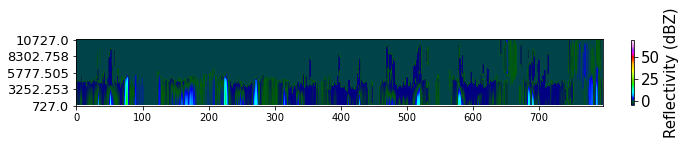

In [59]:
# DRAFT PLOT -- LOOK AT THE TIME INDEXES!!
img = np.zeros(len(reflectivities)*100).reshape(100, len(reflectivities))
altitudes = np.append(heights[0][::25], heights[0][-1])

for i in range(len(reflectivities)):
    img[:, i] = np.flip(reflectivities[i])

# Figure
plt.figure(figsize=(10,10))
plt.imshow(img, cmap="gist_ncar", vmin=-5, vmax=70)
# Ylabels and Ticks
plt.yticks([0, 25, 50, 75, 100], np.flip(np.round(altitudes, 3)), fontsize=13)

# Reflectivity Bar
# Calculate the ratio: height_of_image / width_of_image
ratio = img.shape[0]/img.shape[1]
# Plot colorbar
cbar = plt.colorbar(fraction=0.047*ratio)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(15)
cbar.set_label('Reflectivity (dBZ)', rotation=90, fontsize=15)

In [24]:
alltimes = np.asarray(rdata['radar_times'])
# set these time indexes according to the graph above!
tidx = [0, 100, 200, 300, 400, 500,600, 700, 796]

times = np.zeros(len(tidx))
for i in range(len(tidx)):
    for n, t in enumerate(alltimes):
        if n == tidx[i]:
            times[i] = t

In [25]:
times # check

array([78137., 79413., 80271., 81121., 82515., 83368., 84220., 85503.,
       86349.])

In [26]:
# We need these times in hours
times/3600

array([21.70472222, 22.05916667, 22.2975    , 22.53361111, 22.92083333,
       23.15777778, 23.39444444, 23.75083333, 23.98583333])

In [27]:
# Convert these times to datetime format
times = np.array(times)

tdelta = np.full(len(times), unixtime) # unixtime seconds from 1 Jan 1970 to 2 Aug 2019

alltimes = times + tdelta
alltimes = np.array(alltimes, dtype="datetime64[s]")

# check
alltimes

array(['2019-08-03T21:42:17', '2019-08-03T22:03:33',
       '2019-08-03T22:17:51', '2019-08-03T22:32:01',
       '2019-08-03T22:55:15', '2019-08-03T23:09:28',
       '2019-08-03T23:23:40', '2019-08-03T23:45:03',
       '2019-08-03T23:59:09'], dtype='datetime64[s]')

In [28]:
times_text = [alltimes[i].astype(str).split("T")[-1] for i in range(len(alltimes))]
times_text # check

['21:42:17',
 '22:03:33',
 '22:17:51',
 '22:32:01',
 '22:55:15',
 '23:09:28',
 '23:23:40',
 '23:45:03',
 '23:59:09']

In [29]:
lats = np.array([])
for i in tidx:
    lats = np.append(lats, np.round(radar_latitudes[i], 2))

In [30]:
longs = np.array([])
for i in tidx:
    longs = np.append(longs, np.round(radar_longitudes[i], 2))

In [31]:
lats, longs

(array([47.98, 47.83, 48.07, 48.17, 47.93, 47.96, 47.95, 48.08, 48.34]),
 array([-116.84, -119.08, -118.85, -118.53, -118.17, -117.84, -117.77,
        -117.45, -117.07]))

In [32]:
timelocs = []

for i in range(len(alltimes)):
    
    temp = times_text[i] + "\n-----\n" + str(lats[i]) + "°N\n" + str(longs[i]) + "°E"
    timelocs.append(temp)
    
timelocs

['21:42:17\n-----\n47.98°N\n-116.84°E',
 '22:03:33\n-----\n47.83°N\n-119.08°E',
 '22:17:51\n-----\n48.07°N\n-118.85°E',
 '22:32:01\n-----\n48.17°N\n-118.53°E',
 '22:55:15\n-----\n47.93°N\n-118.17°E',
 '23:09:28\n-----\n47.96°N\n-117.84°E',
 '23:23:40\n-----\n47.95°N\n-117.77°E',
 '23:45:03\n-----\n48.08°N\n-117.45°E',
 '23:59:09\n-----\n48.34°N\n-117.07°E']

In [33]:
# Extracting All Lidar Plume Heights
lheights = rdata['lidar_heights']
plumes = np.zeros(len(rdata))

for row in range(0, len(lheights)):
    if lheights[row] < 0:
        plumes[row] = -1
    else:
        plumes[row] = lheights[row]

zplumes = np.zeros(len(rdata))
for i, h in enumerate(heights):
    if plumes[i] < 0:
        zplumes[i] = 0
    else:
        zplumes[i] = np.abs(heights[0] - plumes[i]).argmin()

In [34]:
# Extracting lidar heights within gridbox
lowerlat = rdata[rdata['lat']>=47.85]
upperlat = lowerlat[lowerlat['lat']<=48.05]
lowerlong = upperlat[upperlat['long']>=-118.70]
gridbox = lowerlong[lowerlong['long']<=-118.30]

lidarbox = np.zeros(len(zplumes))

for i , z in enumerate(zplumes):
    if i in np.asarray(gridbox.index):
        lidarbox[i] = zplumes[i]
    else:
        lidarbox[i] = np.NaN

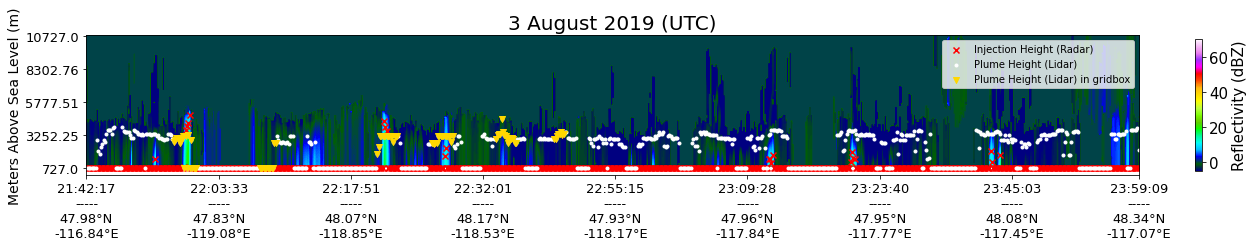

In [61]:
# REFLECTIVITY CROSS SECTION

img = np.zeros(len(reflectivities)*100).reshape(100, len(reflectivities))

for i in range(len(reflectivities)):
    img[:, i] = np.flip(reflectivities[i])
    
# Z-position
zpos = np.zeros(len(rdata))
for i, h in enumerate(injections):
    for z, a in enumerate(heights[0]):
        if np.isclose(h, a):
            zpos[i] = z
#         if h < 0:
#             zpos[i] = np.NaN

# Figure
plt.figure(figsize=(20,10))
# plt.figure(figsize=(8,6))
plt.imshow(img, cmap="gist_ncar", vmin=-5, vmax=70)
# Ylabels and Ticks
plt.yticks([0, 25, 50, 75, 100], np.flip(np.round(altitudes, 2)), fontsize=13)
plt.xticks(tidx, timelocs, fontsize=13)
# Uncomment and edit the following line if you want to crop the graph along x-axis
# plt.xlim([0, 200])

plt.ylabel("Meters Above Sea Level (m)", fontsize=14)
plt.title(str(dateNum)+" August 2019 (UTC)", fontsize=20)

# Reflectivity Bar
# Calculate the ratio: height_of_image / width_of_image
ratio = img.shape[0]/img.shape[1]
# ratio = img.shape[0]/596
# Plot colorbar
cbar = plt.colorbar(fraction=0.047*ratio)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(15)
cbar.set_label('Reflectivity (dBZ)', rotation=90, fontsize=15)

plt.scatter(np.arange(len(rdata)), 100-zpos, marker="x", color="red", label="Injection Height (Radar)")
plt.scatter(np.arange(len(rdata)), 100-zplumes, marker='.', color='white', label="Plume Height (Lidar)")
plt.scatter(np.arange(len(rdata)), 100-lidarbox, marker='v', color='gold', label="Plume Height (Lidar) in gridbox")
plt.legend(loc="upper right")

# Uncomment if satisfied with plot
plt.savefig("3Aug2019-lidarcomparison-ref.png")

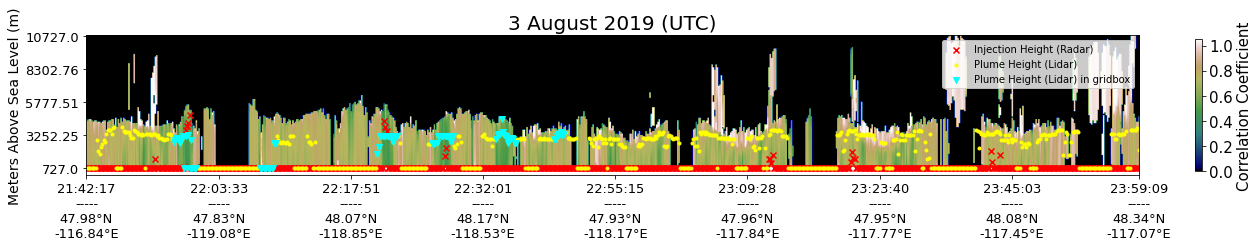

In [63]:
# CORRELATION COEFFICIENTS
img = np.zeros(len(reflectivities)*100).reshape(100, len(correlations))

for i in range(len(correlations)):
    img[:, i] = np.flip(correlations[i])
    
# Z-position
zpos = np.zeros(len(rdata))
for i, h in enumerate(injections):
    for z, a in enumerate(heights[0]):
        if np.isclose(h, a):
            zpos[i] = z
#         if h < 0:
#             zpos[i] = np.NaN

# Figure
plt.figure(figsize=(20,10))
# plt.figure(figsize=(6,6))
plt.imshow(img, cmap="gist_earth", vmin=0.0, vmax=1.05)
# Ylabels and Ticks
plt.yticks([0, 25, 50, 75, 100], np.flip(np.round(altitudes, 2)), fontsize=13)
plt.xticks(tidx, timelocs, fontsize=13)
# plt.xlim([0, 120])
# plt.xlim([0, 110])

plt.ylabel("Meters Above Sea Level (m)", fontsize=14)
plt.title(str(dateNum)+" August 2019 (UTC)", fontsize=20)

# Reflectivity Bar
# Calculate the ratio: height_of_image / width_of_image
ratio = img.shape[0]/img.shape[1]
# ratio = img.shape[0]/110
# Plot colorbar
cbar = plt.colorbar(fraction=0.047*ratio)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(15)
cbar.set_label('Correlation Coefficient', rotation=90, fontsize=15)

plt.scatter(np.arange(len(rdata)), 100-zpos, marker="x", color="red", label="Injection Height (Radar)")
plt.scatter(np.arange(len(rdata)), 100-zplumes, marker='.', color='yellow', label="Plume Height (Lidar)")
plt.scatter(np.arange(len(rdata)), 100-lidarbox, marker='v', color='aqua', label="Plume Height (Lidar) in gridbox")
plt.legend(loc="upper right")

# Uncomment if satisfied with plot
plt.savefig("3Aug2019-lidarcomparison-coef.png")